# CEIA - Procesamiento de Lenguaje Natural

## Estudiante: a2124 - Ricardo Silvera

---

# Desafío 4

### Datos
El objecto es utilizar datos disponibles del Tatoeba Project de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor de inglés a español seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [ ]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.layers import Input
from keras.utils import plot_model

In [ ]:
# Descargar la carpeta de dataset

import os
if os.access('spa-eng', os.F_OK) is False:
    if os.access('spa-eng.zip', os.F_OK) is False:
        !curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2576k  100 2576k    0     0  32.8M      0 --:--:-- --:--:-- --:--:-- 33.1M


In [ ]:
# dataset_file

text_file = "./spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 6000

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    # el tabulador señaliza la separación entre las oraciones
    # en ambos idiomas
    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 6000


In [ ]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2 - Preprocesamiento

In [ ]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 6000
# Vamos a necesitar un tokenizador para cada idioma

In [ ]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 3851
Sentencia de entrada más larga: 32


In [ ]:
# tokenizador de español
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 5721
Sentencia de salida más larga: 36


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

In [ ]:
max_input_len = 16
max_out_len = 18

A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [ ]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6000
encoder_input_sequences shape: (6000, 16)
decoder_input_sequences shape: (6000, 18)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [ ]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6000, 18, 5722)

### 3 - Preparar los embeddings

In [ ]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=3eef47ad-3548-47cf-b207-f0f509ff2da9
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:05<00:00, 100MB/s]


In [ ]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [ ]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [ ]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# Ajustar nb_words para la capa de embedding (para 0-indexing y todos los índices generados por el tokenizer)
nb_words_for_embedding = len(word2idx_inputs) + 1 # len(word2idx_inputs) es el índice más alto + 1 para la dimensión total

embedding_matrix = np.zeros((nb_words_for_embedding, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words_for_embedding:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

# La variable global nb_words debe ser actualizada para ser usada en crear_modelo
nb_words = nb_words_for_embedding

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))


preparing embedding matrix...
number of null word embeddings: 30


In [ ]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(3852, 50)

### 4 - Entrenar el modelo

In [ ]:
max_input_len

16

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 16, 50)    │    192,600 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 18, 128)   │    732,416 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │     91,648 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 18, 128), │    131,584 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 18, 5722)  │    738,138 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,886,386 (7.20 MB)

 Trainable params: 1,693,786 (6.46 MB)

 Non-trainable params: 192,600 (752.34 KB)

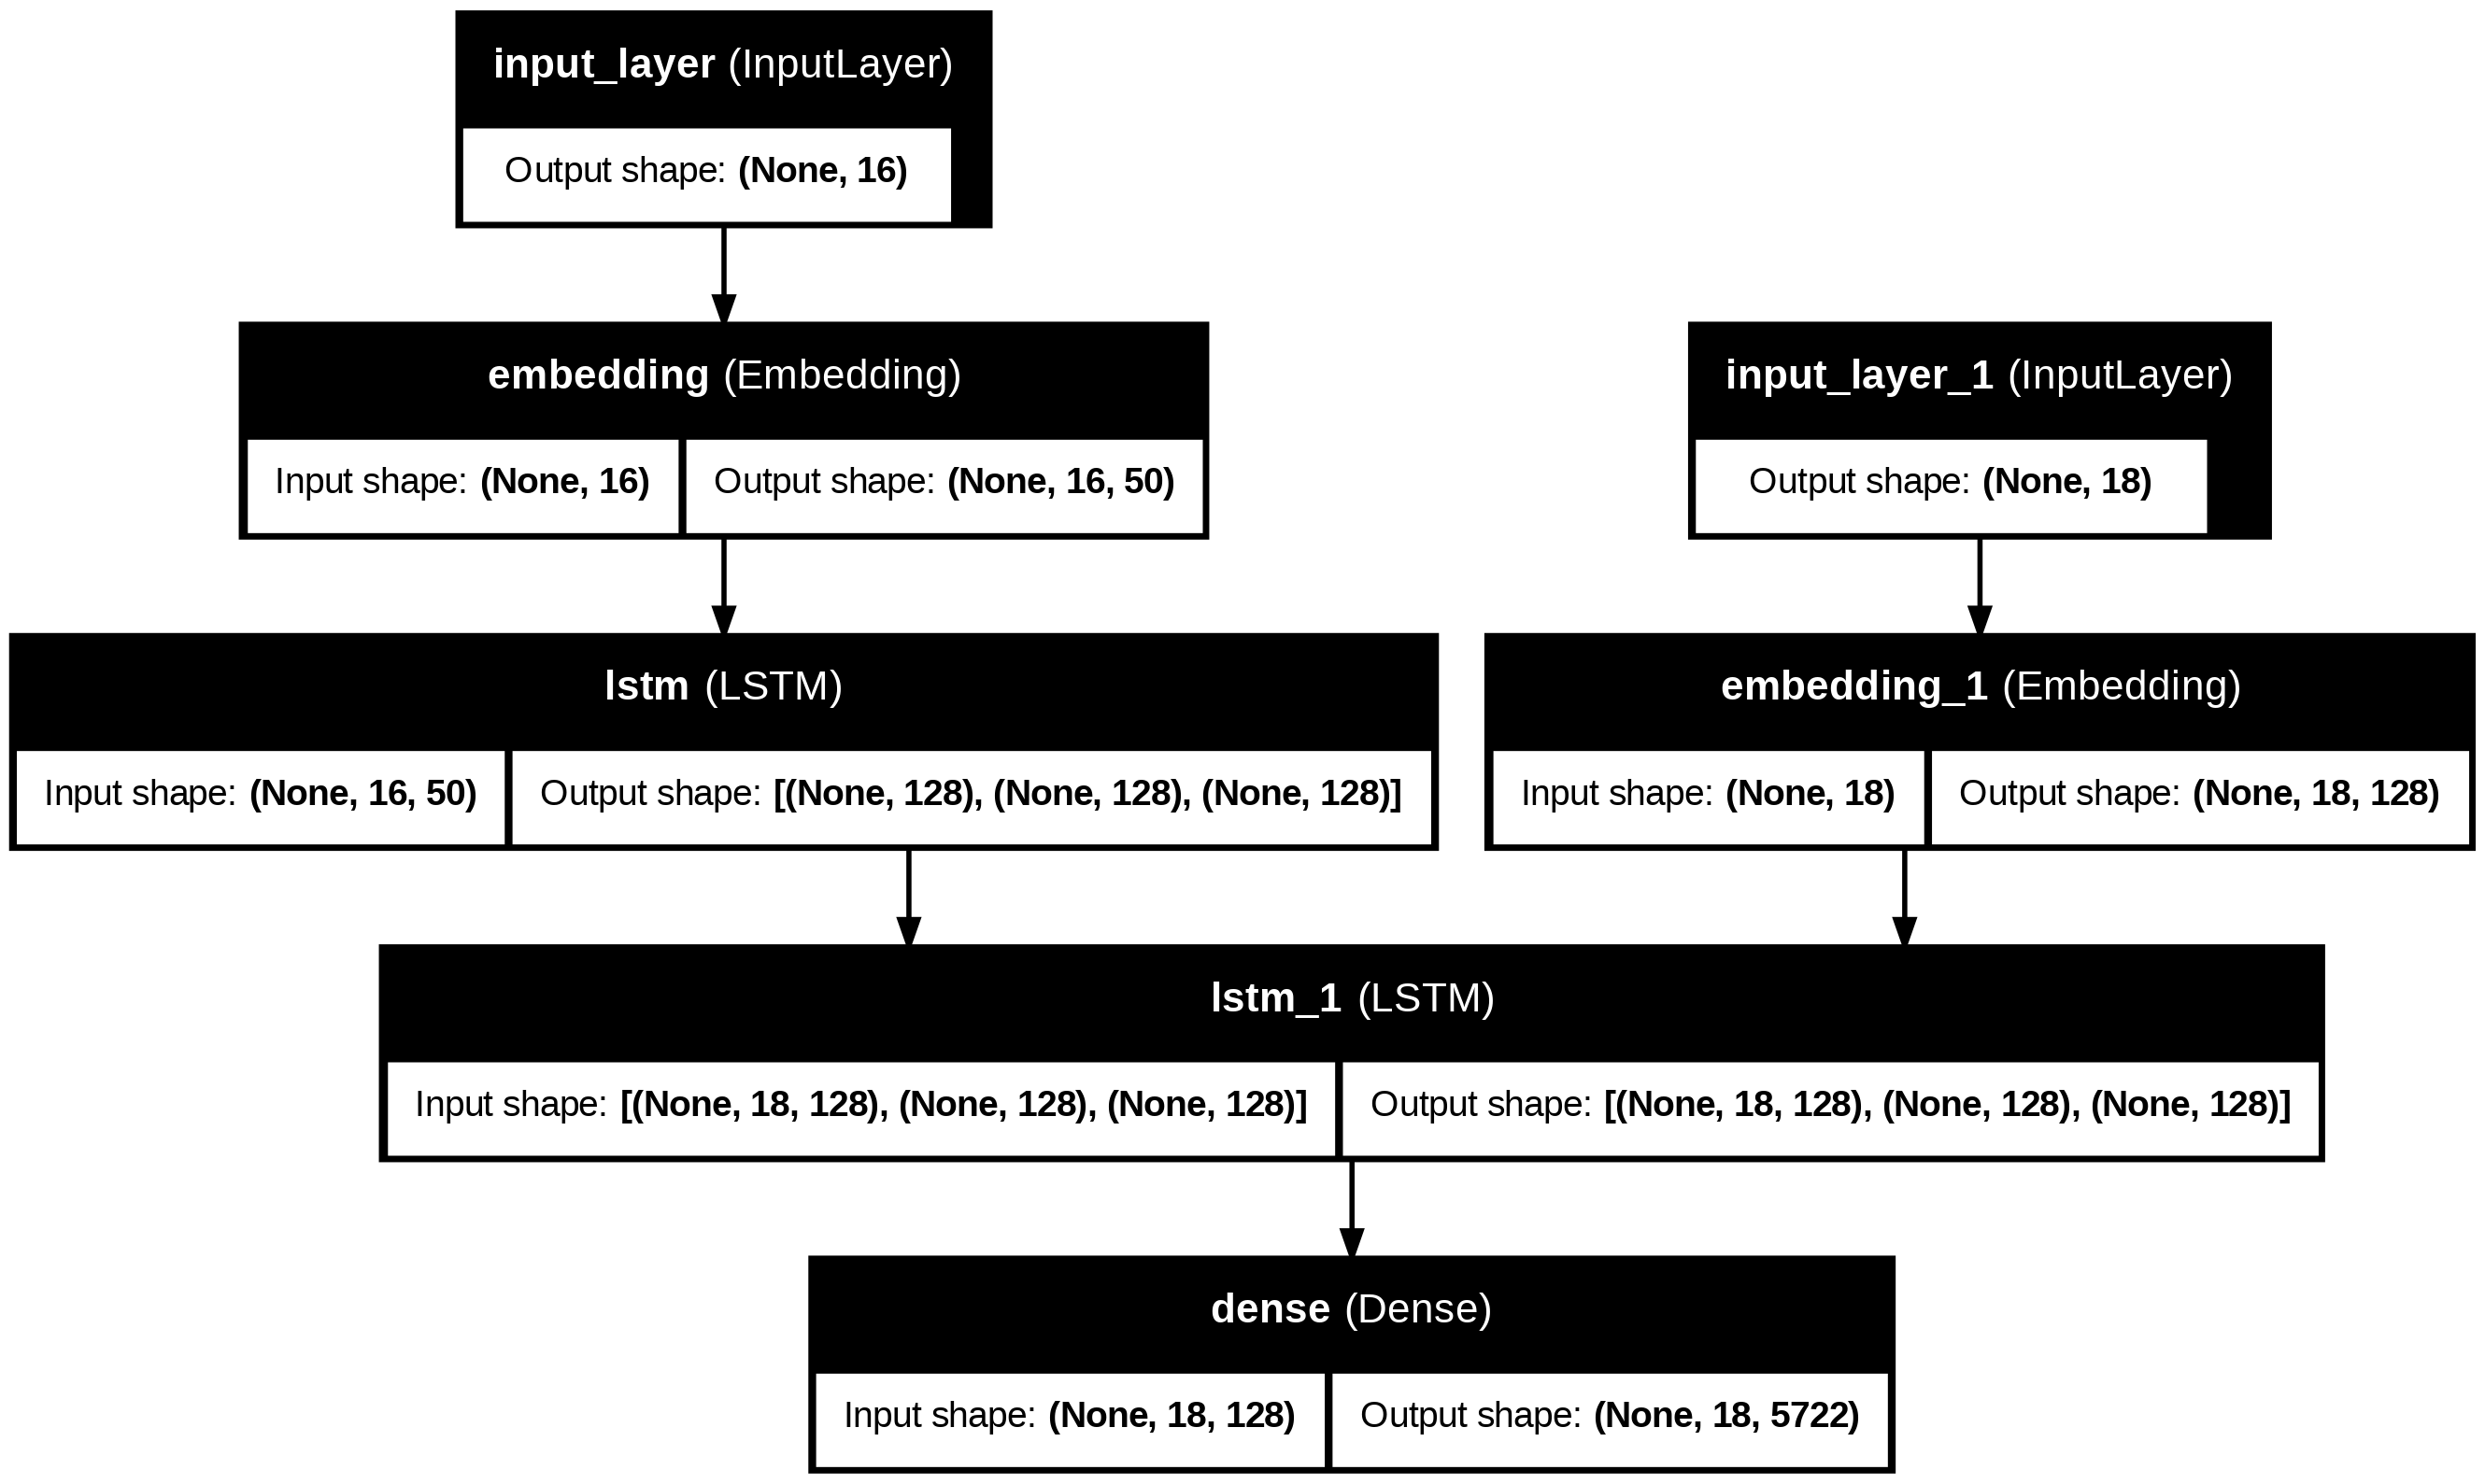

In [ ]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

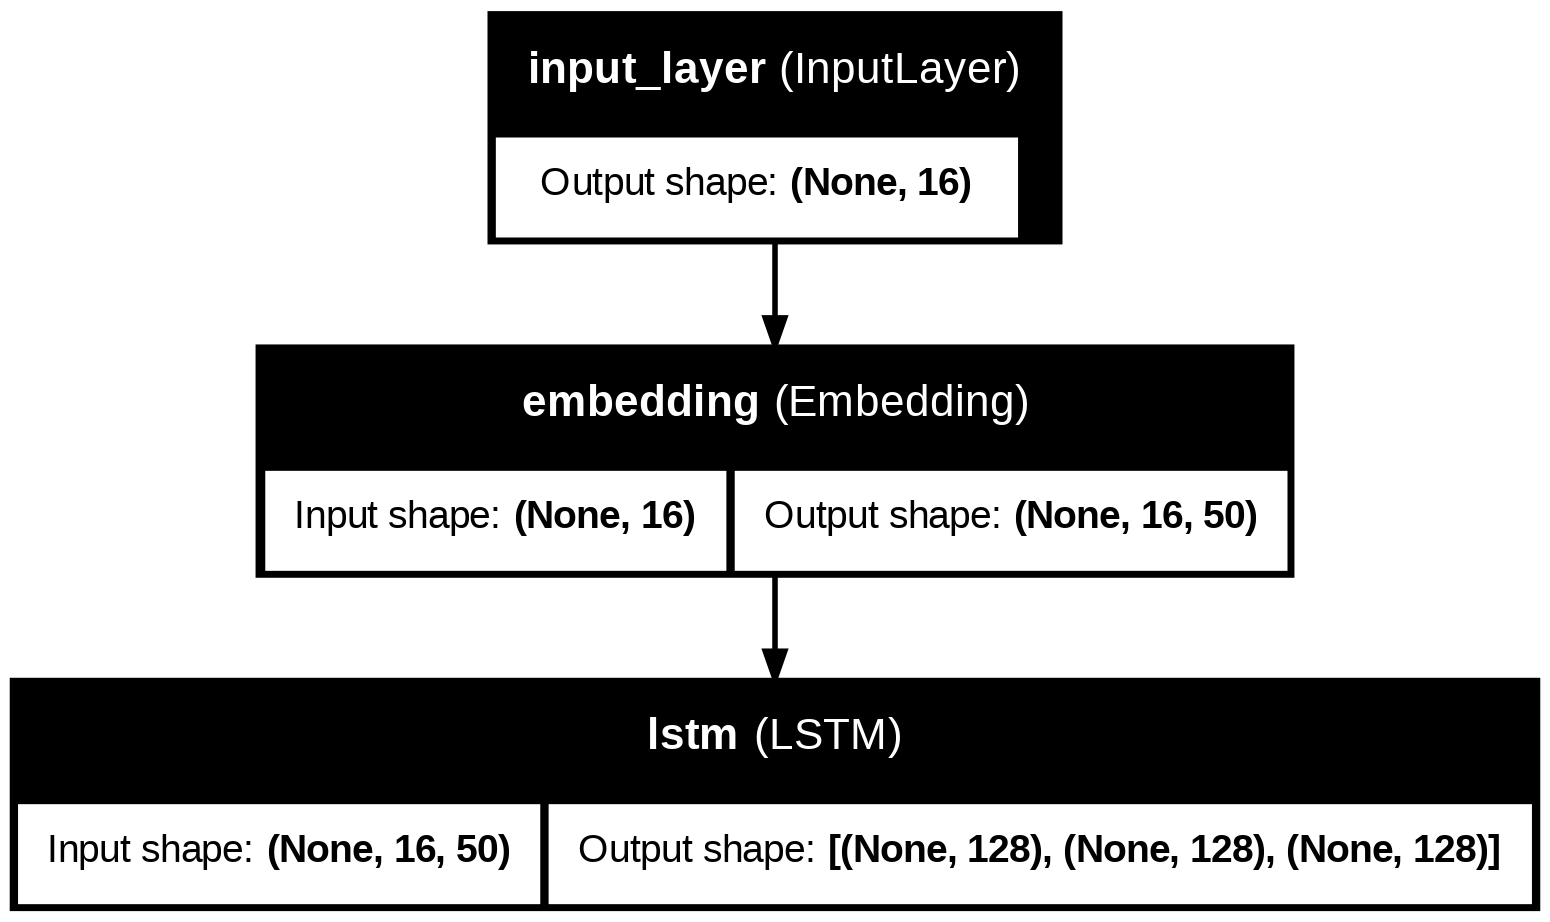

In [ ]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

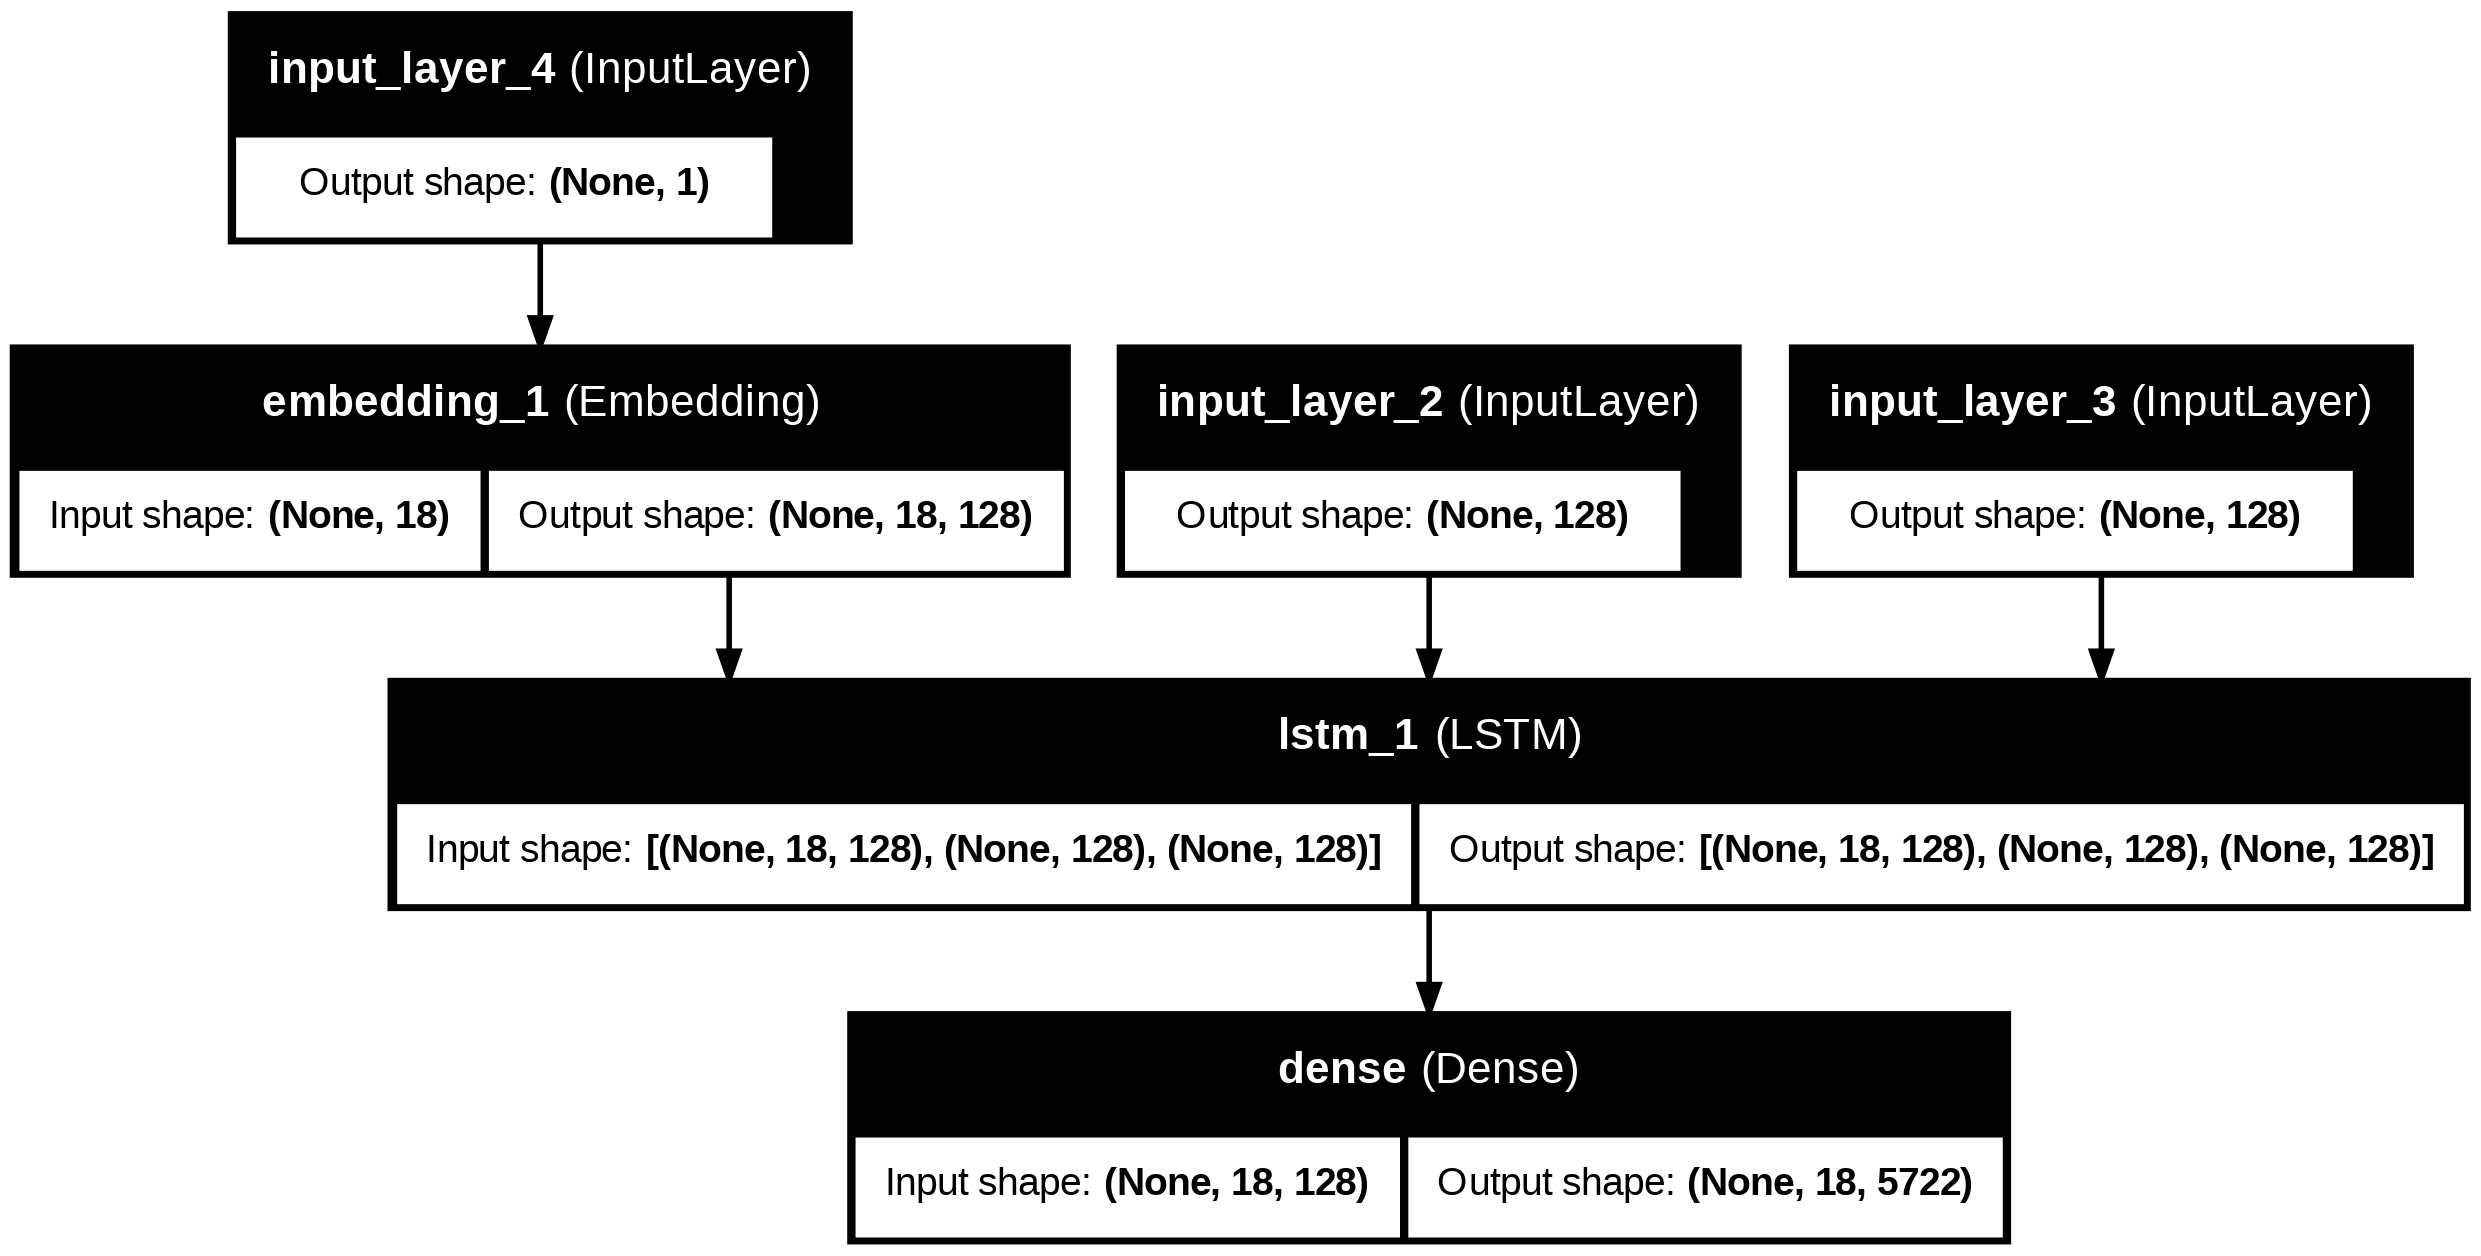

In [ ]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=30,
    validation_split=0.2)

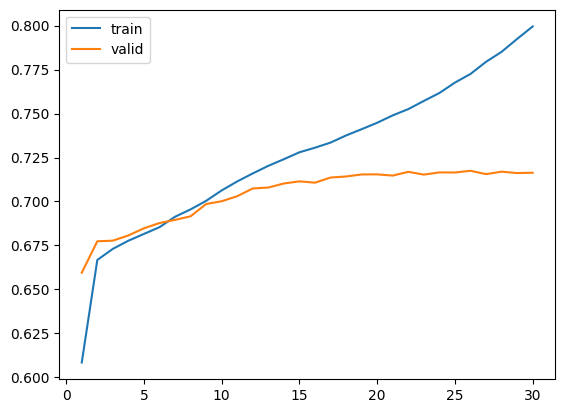

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [ ]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

'\nStep 1:\nA deal is a deal -> Encoder -> enc(h1,c1)\n\nenc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)\n\nstep 2:\ndec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)\n\nstep 3:\ndec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)\n\nstep 4:\ndec(h3,c3) + es -> Decoder -> un + dec(h4,c4)\n\nstep 5:\ndec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)\n\nstep 6:\ndec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)\n'

In [ ]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
-
Input: Mary wants to buy a dress.
Response: mary se dio mucho que hacer


In [ ]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [15, 225, 134]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  15 225 134]]
Input: My mother say hi.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Response: me duele la cabeza


# Desarrollo del desafío

En base al traductor inicial visto en clase, voy a realizar diferentes pruebas de parámetrós y cambios en la arquitectura del modelo para entrenar diferentes variantes y comparar los resultados.


##  Preprocesamiento de Datos

MAX_NUM_SENTENCES: 6000

MAX_VOCAB_SIZE: 8000

max_input_len: 16

max_out_len: 18

epochs: 30.

Optimizador: Adam

Learning Rate: 0.001

Batch Size:

Dropout: 0

validation_split= 0.2


Creo un funcion auxilar que me permita crear el modelo en base a estos parámetros

In [ ]:
from tensorflow.keras.optimizers import Adam # Importar el optimizador Adam

def crear_modelo(
    nb_words,
    embed_dim,
    embedding_matrix,
    num_words_output,
    max_input_len=16,
    max_out_len=18,
    n_units=128,
    optimizer_name='Adam',
    learning_rate=0.001,
    dropout_rate=0.0
):
  # define training encoder
  encoder_inputs = Input(shape=(max_input_len,))

  encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador, ahora ajustado a len(word2idx_inputs) + 1
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

  encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

  encoder = LSTM(n_units, return_state=True)
  encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
  encoder_states = [state_h, state_c]

  # define training decoder
  decoder_inputs = Input(shape=(max_out_len,))
  decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units)
  decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

  decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

  # Añadir capa de Dropout si se especifica un dropout_rate > 0
  if dropout_rate > 0:
      decoder_outputs = Dropout(dropout_rate)(decoder_outputs)

  # Dense
  decoder_dense = Dense(num_words_output, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  # Configurar el optimizador
  if optimizer_name == 'Adam':
      optimizer = Adam(learning_rate=learning_rate)
  # Puedes añadir más optimizadores aquí si lo deseas
  else:
      print(f"Advertencia: Optimizador '{optimizer_name}' no soportado. Usando Adam por defecto.")
      optimizer = Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

Función para entrenar el modelo, lo guarda para poder recuperarlo en otro momento

In [ ]:
import os

def entrenar_modelo(
    model,
    model_name,
    encoder_input_sequences,
    decoder_input_sequences,
    decoder_targets,
    validation_split=0.2,
    epochs=30,
    save_path=None
):
    print(f"\n--- Entrenando {model_name} ---")

    # Entrenar el modelo
    history = model.fit(
        [encoder_input_sequences, decoder_input_sequences],
        decoder_targets,
        epochs=epochs,
        validation_split=validation_split,
        verbose=1
    )

    # Guardar los pesos del modelo si se proporciona una ruta
    if save_path:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        model_save_path = os.path.join(save_path, f'{model_name.replace(" ", "_").lower()}.weights.h5')
        model.save_weights(model_save_path)
        print(f"Pesos del modelo '{model_name}' guardados en: {model_save_path}")

    print(f"Entrenamiento de {model_name} completado.")
    return history

Función para visualizar el rendimiento del modelo

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualizar_rendimiento(history, model_name):
    """
    Grafica las curvas de pérdida y precisión (accuracy) para el conjunto de entrenamiento y validación.

    Args:
        history (keras.callbacks.History): Objeto de historial de entrenamiento devuelto por model.fit().
        model_name (str): Nombre del modelo para usar en los títulos de los gráficos.
    """
    plt.figure(figsize=(12, 5))

    # Gráfico de Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Loss de Entrenamiento')
    plt.plot(history['val_loss'], label='Loss de Validación')
    plt.title(f"Curva de Loss - {model_name}")
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfico de Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Accuracy de Entrenamiento')
    plt.plot(history['val_accuracy'], label='Accuracy de Validación')
    plt.title(f"Curva de Accuracy - {model_name}")
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [ ]:
resultados_modelos = []
print("Lista 'resultados_modelos' inicializada.")

Lista 'resultados_modelos' inicializada.


## Entrenamiento 1

El modelo inicial es similar al propuesto en el desafío. El **accuracy** en torno al 0.71 y se observa overfitting muy grande ya que el **loss** de validación no mejora a diferencia del **loss** de entrenamiento.


--- Entrenando Modelo 1  ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 16, 50)    │    192,600 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 18, 128)   │    732,416 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 128),     │     91,648 │ embedding_2[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 18, 128), │    131,584 │ embedding_3[0][0… │
│                     │ (None, 128),      │            │ lstm_2[0][1],     │
│                     │ (None, 128)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 18, 5722)  │    738,138 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,886,386 (7.20 MB)

 Trainable params: 1,693,786 (6.46 MB)

 Non-trainable params: 192,600 (752.34 KB)


--- Entrenando Modelo 1 ---
Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 325ms/step - accuracy: 0.5852 - loss: 4.8261 - val_accuracy: 0.6623 - val_loss: 2.3881
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 302ms/step - accuracy: 0.6669 - loss: 2.3127 - val_accuracy: 0.6758 - val_loss: 2.3092
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 297ms/step - accuracy: 0.6713 - loss: 2.2474 - val_accuracy: 0.6787 - val_loss: 2.2760
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 305ms/step - accuracy: 0.6770 - loss: 2.1789 - val_accuracy: 0.6832 - val_loss: 2.2423
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 303ms/step - accuracy: 0.6791 - loss: 2.1240 - val_accuracy: 0.6844 - val_loss: 2.2053
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 310ms/step - accuracy: 0.6866 - loss: 2.0359 - val_accuracy: 0.6909 - val_loss: 2.1704
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 313ms/step - accuracy: 0.6923 - loss: 1.9780 - val_accuracy: 0.6925 - val_loss: 2.1394
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 311ms/step

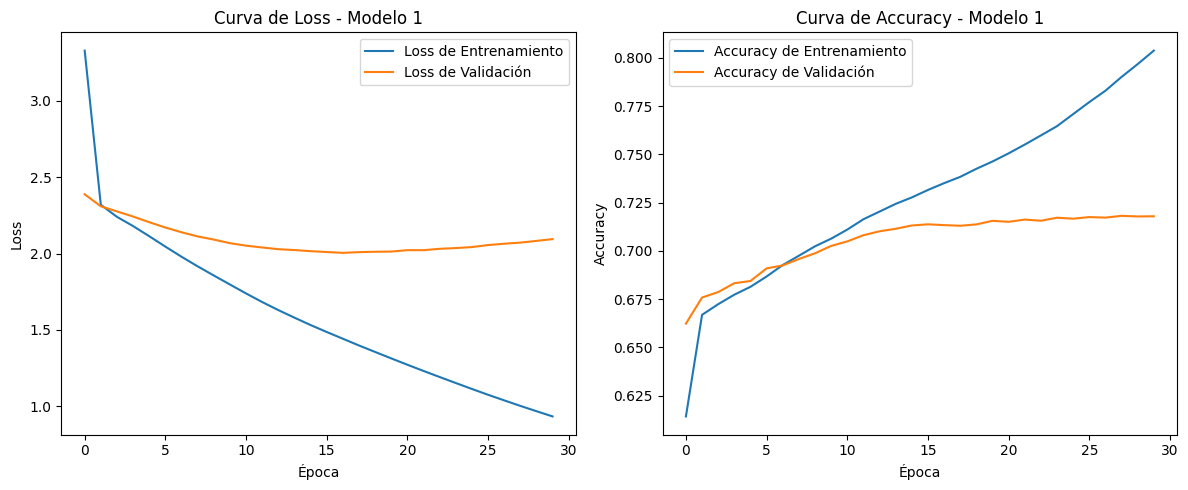

In [ ]:
print("\n--- Entrenando Modelo 1  ---")

# Crear el Modelo 1
model_1 = crear_modelo(
    nb_words=nb_words,
    embed_dim=embed_dim,
    embedding_matrix=embedding_matrix,
    num_words_output=num_words_output,
    max_input_len=16,
    max_out_len=18,
    n_units=128,
    optimizer_name='Adam',
    learning_rate=0.001,
    dropout_rate=0.0
)
model_1.summary()

history_1=entrenar_modelo(
    model_1,
    'Modelo 1',
    encoder_input_sequences,
    decoder_input_sequences,
    decoder_targets,
)

visualizar_rendimiento(history_1.history, 'Modelo 1')

resultados_modelos.append({
    'modelo': 'Modelo 1',
    'history': history_1.history
})
#

## Etrenamiento 2

Aumenté los valores de max_input_len y max_out_len para podes observar el cambio con respecto al primer modelo. No es significativa la modificación y los resultado son muy similares al primer caso. el aumento de las logitudes de las secuencias de entrada y salida aumenta la utilización de memoria exponencialmente. Debido a la limitación ene los recursos no los puede variar deaciado.

Cantidad de rows del dataset: 6000
encoder_input_sequences shape: (6000, 18)
decoder_input_sequences shape: (6000, 20)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 18, 50)    │    192,550 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 20, 128)   │    732,416 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │     91,648 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 20, 128), │    131,584 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20, 5722)  │    738,138 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,886,336 (7.20 MB)

 Trainable params: 1,693,786 (6.46 MB)

 Non-trainable params: 192,550 (752.15 KB)


--- Entrenando Modelo 2 ---
Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.6192 - loss: 4.7446 - val_accuracy: 0.6959 - val_loss: 2.1589
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6972 - loss: 2.1143 - val_accuracy: 0.7083 - val_loss: 2.0747
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7077 - loss: 2.0041 - val_accuracy: 0.7126 - val_loss: 2.0351
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7093 - loss: 1.9559 - val_accuracy: 0.7149 - val_loss: 2.0030
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7108 - loss: 1.9107 - val_accuracy: 0.7171 - val_loss: 1.9719
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7194 - loss: 1.8216 - val_accuracy: 0.7207 - val_loss: 1.9432
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7246 - loss: 1.7673 - val_accuracy: 0.7244 - val_loss: 1.9192
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0

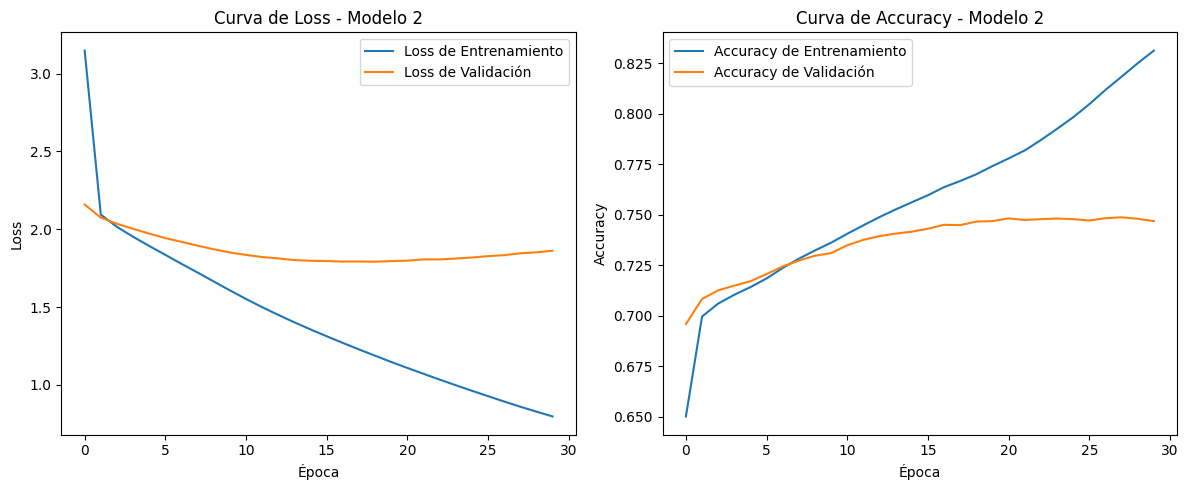

In [ ]:
# Crear el Modelo 2
max_input_len=18
max_out_len=20

print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

model_2 = crear_modelo(
    nb_words=nb_words,
    embed_dim=embed_dim,
    embedding_matrix=embedding_matrix,
    num_words_output=num_words_output,
    max_input_len=max_input_len,
    max_out_len=max_out_len,
    n_units=128,
    optimizer_name='Adam',
    learning_rate=0.001,
    dropout_rate=0.0
)
model_2.summary()

history_2=entrenar_modelo(
    model_2,
    'Modelo 2',
    encoder_input_sequences,
    decoder_input_sequences,
    decoder_targets,
)

visualizar_rendimiento(history_2.history, 'Modelo 2')

resultados_modelos.append({
    'modelo': 'Modelo 2',
    'history': history_2.history
})


## Entrenamiento 3

En base a los resultados del Entrenamiento 2, aumenté **max_imput** y **max_out** lo máximo posible con los recursos disponibles. Disminuí el valor de **learning rate** a la mitad. Se logra una curva más suave, pero se observa el overfitting es menor pero aún existe ya que el error en train disminuye y en validación no mejora conciderablemente luego de las primeras épocas

Cantidad de rows del dataset: 6000
encoder_input_sequences shape: (6000, 20)
decoder_input_sequences shape: (6000, 22)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 20, 50)    │    192,550 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 22, 128)   │    732,416 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 128),     │     91,648 │ embedding_2[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 22, 128), │    131,584 │ embedding_3[0][0… │
│                     │ (None, 128),      │            │ lstm_2[0][1],     │
│                     │ (None, 128)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 22, 5722)  │    738,138 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,886,336 (7.20 MB)

 Trainable params: 1,693,786 (6.46 MB)

 Non-trainable params: 192,550 (752.15 KB)


--- Entrenando Modelo 2 ---
Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.6483 - loss: 5.5742 - val_accuracy: 0.6783 - val_loss: 2.0768
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6917 - loss: 2.0157 - val_accuracy: 0.7288 - val_loss: 1.9531
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7231 - loss: 1.9432 - val_accuracy: 0.7320 - val_loss: 1.9046
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7288 - loss: 1.8721 - val_accuracy: 0.7358 - val_loss: 1.8781
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7311 - loss: 1.8281 - val_accuracy: 0.7391 - val_loss: 1.8538
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7370 - loss: 1.7827 - val_accuracy: 0.7393 - val_loss: 1.8327
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7360 - loss: 1.7597 - val_accuracy: 0.7421 - val_loss: 1.8131
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7

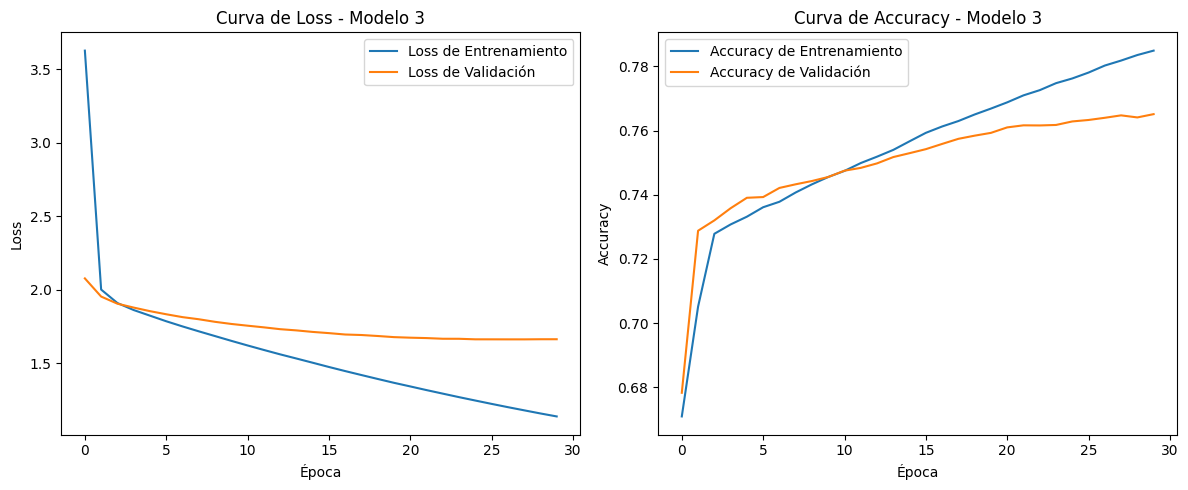

In [ ]:
# Crear el Modelo 3
max_input_len=20
max_out_len=22

print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

model_3= crear_modelo(
    nb_words=nb_words,
    embed_dim=embed_dim,
    embedding_matrix=embedding_matrix,
    num_words_output=num_words_output,
    max_input_len=max_input_len,
    max_out_len=max_out_len,
    n_units=128,
    optimizer_name='Adam',
    learning_rate=0.0005,
    dropout_rate=0.0
)
model_3.summary()

history_3=entrenar_modelo(
    model_3,
    'Modelo 3',
    encoder_input_sequences,
    decoder_input_sequences,
    decoder_targets,
)

visualizar_rendimiento(history_3.history, 'Modelo 3')

resultados_modelos.append({
    'modelo': 'Modelo 3',
    'history': history_3.history
})

## Entrenamiento 4

Liberando toda la memoria posible, pude auentar un poco más **max_input_len** y **max_out_len**. Para poder miticar el overfitting agregue **dropout** para desactivar el 20% de las neuronas en la etpa de entrenamiento.

Cantidad de rows del dataset: 6000
encoder_input_sequences shape: (6000, 20)
decoder_input_sequences shape: (6000, 22)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 20, 50)    │    192,600 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 22, 128)   │    732,416 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 128),     │     91,648 │ embedding_4[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 22, 128), │    131,584 │ embedding_5[0][0… │
│                     │ (None, 128),      │            │ lstm_4[0][1],     │
│                     │ (None, 128)]      │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 22, 128)   │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 22, 5722)  │    738,138 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,886,386 (7.20 MB)

 Trainable params: 1,693,786 (6.46 MB)

 Non-trainable params: 192,600 (752.34 KB)


--- Entrenando Modelo 4 ---
Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 57s 356ms/step - accuracy: 0.6368 - loss: 5.5957 - val_accuracy: 0.6783 - val_loss: 2.0817
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 372ms/step - accuracy: 0.6864 - loss: 2.0405 - val_accuracy: 0.7308 - val_loss: 1.9484
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 341ms/step - accuracy: 0.7266 - loss: 1.9229 - val_accuracy: 0.7322 - val_loss: 1.8995
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 338ms/step - accuracy: 0.7318 - loss: 1.8608 - val_accuracy: 0.7356 - val_loss: 1.8736
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 336ms/step - accuracy: 0.7303 - loss: 1.8463 - val_accuracy: 0.7375 - val_loss: 1.8538
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 84s 348ms/step - accuracy: 0.7306 - loss: 1.8196 - val_accuracy: 0.7390 - val_loss: 1.8368
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 342ms/step - accuracy: 0.7327 - loss: 1.7874 - val_accuracy: 0.7399 - val_loss: 1.8216
Epoch 8/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 334ms/step

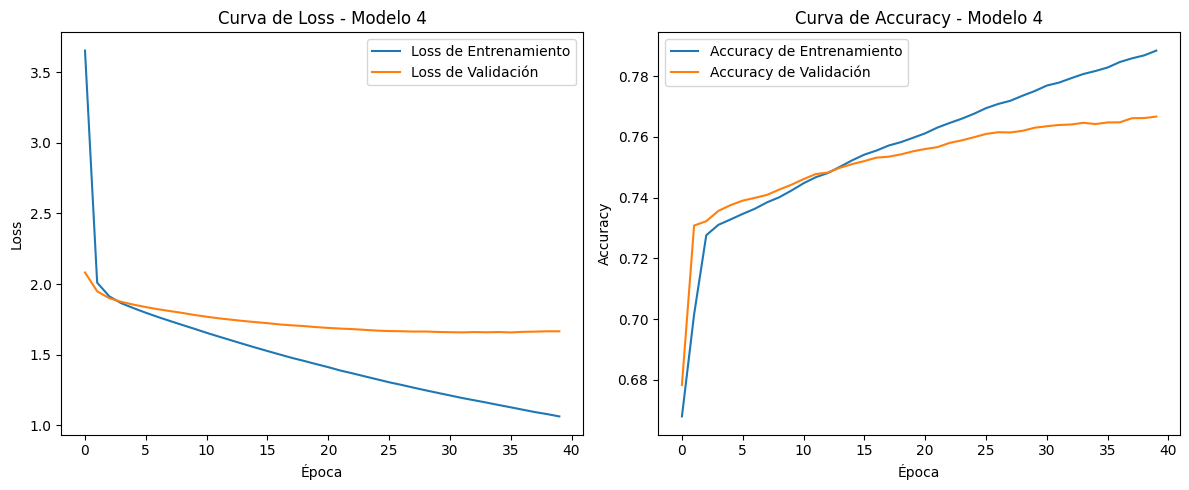

In [ ]:
# Crear el Modelo 4

max_input_len=20
max_out_len=22

print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

model_4= crear_modelo(
    nb_words=nb_words,
    embed_dim=embed_dim,
    embedding_matrix=embedding_matrix,
    num_words_output=num_words_output,
    max_input_len=max_input_len,
    max_out_len=max_out_len,
    n_units=128,
    optimizer_name='Adam',
    learning_rate=0.0005,
    dropout_rate=0.2
)
model_4.summary()

history_4=entrenar_modelo(
    model_4,
    'Modelo 4',
    encoder_input_sequences,
    decoder_input_sequences,
    decoder_targets,
    epochs=40,
    save_path='modelo_guardado' # Agregado para guardar los pesos
)

visualizar_rendimiento(history_4.history, 'Modelo 4')

resultados_modelos.append({
    'modelo': 'Modelo 4',
    'history': history_4.history
})


In [31]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense

# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

# --- 1. Modelos de inferencia para MODELO_4 ---
# n_units se mantiene igual que en la creación de model_4
n_units_inference = 128

# Encoder de inferencia para model_4
# Se extraen solo los estados h y c del encoder LSTM
encoder_outputs, state_h_enc, state_c_enc = model_4.get_layer(name='lstm_4').output
encoder_model_4_inference = Model(model_4.input[0], [state_h_enc, state_c_enc])

# Decoder de inferencia para model_4
decoder_state_input_h_4 = Input(shape=(n_units_inference,))
decoder_state_input_c_4 = Input(shape=(n_units_inference,))
decoder_states_inputs_4 = [decoder_state_input_h_4, decoder_state_input_c_4]

decoder_inputs_single_4 = Input(shape=(1,))

# Re-instanciar las capas del decoder
decoder_embedding_layer_inference = Embedding(
    input_dim=num_words_output,
    output_dim=n_units_inference,
    weights=model_4.get_layer(name='embedding_5').get_weights(),
    trainable=False
)
decoder_inputs_single_x_4 = decoder_embedding_layer_inference(decoder_inputs_single_4)

# Decoder LSTM Layer
decoder_lstm_inference = LSTM(
    n_units_inference,
    return_sequences=True,
    return_state=True
)

# Decoder Dense Layer
decoder_dense_inference = Dense(
    num_words_output,
    activation='softmax'
)

decoder_outputs_4, state_h_4, state_c_4 = decoder_lstm_inference(
    decoder_inputs_single_x_4, initial_state=decoder_states_inputs_4
)
decoder_states_4 = [state_h_4, state_c_4]
decoder_outputs_4 = decoder_dense_inference(decoder_outputs_4)

decoder_model_4_inference = Model(
    [decoder_inputs_single_4] + decoder_states_inputs_4,
    [decoder_outputs_4] + decoder_states_4
)

# Set weights for LSTM and Dense layers AFTER the model has been constructed
decoder_lstm_inference.set_weights(model_4.get_layer(name='lstm_5').get_weights())
decoder_dense_inference.set_weights(model_4.get_layer(name='dense_2').get_weights())

# --- 2. Función de traducción adaptada ---
def translate_sentence_model_4(input_seq):
    # Se transforma la secuencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model_4_inference.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len): # max_out_len debe ser el usado en model_4
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model_4_inference.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentence <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0: # Asegurarse de que el índice no sea 0 (padding)
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)



In [49]:
# Prueba 1: Sentencia aleatoria del dataset (5 frases)
print("\n--- Traducciones de 3 frases aleatorias del dataset ---")
for _ in range(3):
    i = np.random.choice(len(input_sentences))
    input_seq_test1 = encoder_input_sequences[i:i+1]
    translation1 = translate_sentence_model_4(input_seq_test1)
    print('-')
    print('Original (inglés):', input_sentences[i])
    print('Traducción Modelo 4:', translation1)
    print('Referencia (español):', output_sentences[i])




--- Traducciones de 3 frases aleatorias del dataset ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
-
Original (inglés): He doesn't know me.
Traducción Modelo 4: no no me gusta
Referencia (español): Él no me conoce. <eos>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
-
Original (inglés): Is there a letter for me?
Traducción Modelo 4: creo que es un poco de que es
Referencia (español): ¿Hay una carta para mí? <eos>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [50]:
# Prueba 2: Sentencia personalizada
input_test_custom = "Where are you going?"
print('\nInput personalizado:', input_test_custom)
integer_seq_custom = input_tokenizer.texts_to_sequences([input_test_custom])[0]
encoder_sequence_custom = pad_sequences([integer_seq_custom], maxlen=max_input_len)
translation_custom = translate_sentence_model_4(encoder_sequence_custom)
print('Traducción Modelo 4:', translation_custom)

input_test_custom2 = "I like pizza."
print('\nInput personalizado:', input_test_custom2)
integer_seq_custom2 = input_tokenizer.texts_to_sequences([input_test_custom2])[0]
encoder_sequence_custom2 = pad_sequences([integer_seq_custom2], maxlen=max_input_len)
translation_custom2 = translate_sentence_model_4(encoder_sequence_custom2)
print('Traducción Modelo 4:', translation_custom2)


Input personalizado: Where are you going?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Traducción Modelo 4: por qué estás haciendo

Input personalizado: I like pizza.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Traducción Modelo 4: me gusta la libro


# Conclusiones

Se observa que, si bien el modelo muestra un avance inicial en la traducción, su capacidad es aún limitada y las traducciones no son correctas.

En varias pruebas, las frases generadas no tienen coherencia semántica o presentan inconsistencias gramaticales, como la falta de concordancia de género entre artículos y sustantivos.

A pesar de la pobreza de lso resultados, se peude destacar que el modelo logra mantener una estructura de frase relativamente correcta en la secuencia de salida. Se aprecian casos donde el modelo captura ciertas características semánticas de la entrada, como la presencia de negaciones o el formato de preguntas. Además, demuestra la capacidad de traducir frases sencillas y comunes, como "I like", de manera correcta.

Estos resultados sugieren que el modelo está aprendiendo patrones fundamentales, pero aún necesita una mayor optimización y quizás más datos o una arquitectura más compleja para alcanzar una calidad de traducción superior.